In [37]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time

- 데이터 읽어오기

In [46]:
df_train = pd.read_csv('/content/drive/MyDrive/ML_PROJECT/ML_Team_Project/data/train.csv/train.csv')
df_train

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0
165030,165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0
165031,165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0
165032,165032,15689614,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0


- 라벨 인코딩

In [7]:
for col in ['Geography', 'Gender']:

  le = LabelEncoder()
  new_col = 'Num_' + col
  df_train[new_col] = le.fit_transform(df_train[col])
  df_train.drop(col, axis=1, inplace=True)

df_train

,id,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Num_Geography,Num_Gender
0,0,15674932,Okwudilichukwu,668,33.0,3,0.00,2,1.0,0.0,181449.97,0,0,1
1,1,15749177,Okwudiliolisa,627,33.0,1,0.00,2,1.0,1.0,49503.50,0,0,1
2,2,15694510,Hsueh,678,40.0,10,0.00,2,1.0,0.0,184866.69,0,0,1
3,3,15741417,Kao,581,34.0,2,148882.54,1,1.0,1.0,84560.88,0,0,1
4,4,15766172,Chiemenam,716,33.0,5,0.00,2,1.0,1.0,15068.83,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,Meng,667,33.0,2,0.00,1,1.0,1.0,131834.75,0,2,0
165030,165030,15665521,Okechukwu,792,35.0,3,0.00,1,0.0,0.0,131834.45,0,0,1
165031,165031,15664752,Hsia,565,31.0,5,0.00,1,1.0,1.0,127429.56,0,0,1
165032,165032,15689614,Hsiung,554,30.0,7,161533.00,1,0.0,1.0,71173.03,0,2,0


- 컬럼 제거
  - id, CustomerId, Surname과 같은 고객 이탈을 예측하는 데에 설명 가능력이 떨어지는 컬럼 제거

In [9]:
y = df_train['Exited']
X = df_train.drop(['id', 'CustomerId', 'Surname', 'Exited'], axis=1)

- 데이터 나누기

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((132027, 10), (33007, 10), (132027,), (33007,))

In [12]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([104090,  27937]))

- 오버 샘플링

In [14]:
smote = SMOTE(random_state=42)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

In [15]:
X_train.shape, y_train.shape

((132027, 10), (132027,))

In [16]:
X_train_over.shape, y_train_over.shape

((208180, 10), (208180,))

In [17]:
np.unique(y_train_over, return_counts=True)

(array([0, 1]), array([104090, 104090]))

- 성능 지표 함수 생성

In [38]:
def print_clf_eval(y_test, pred, pred_proba):

    start_time = time.time()

    acc = accuracy_score(y_test, pred)
    pre = precision_score(y_test, pred)
    re = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred_proba)

    confusion = confusion_matrix(y_test, pred)

    print('=> confusion matrix')
    print(confusion)
    print('=' * 20)

    print('Accuracy : {0:.4f}, Precision : {1:.4f}'.format(acc, pre)) # :.4f는 소수점 4째자리까지 표현하라는 뜻
    print('Recall : {0:.4f}, F1 : {1:.4f}, AUC : {2:.4f}'.format(re, f1, auc))
    print('Fit time : ', time.time() - start_time)
    print()

    return acc, pre, re, f1, auc

In [33]:
def get_result(model, X_train, y_train, X_test, y_test):

  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  pred_proba = model.predict_proba(X_test)[:, 1]

  return print_clf_eval(y_test, pred, pred_proba)

In [34]:
def get_result_pd(models, model_names, X_train, y_train, X_test, y_test):

  col_names = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
  tmp = []

  for model in models:

    tmp.append(get_result(model, X_train, y_train, X_test, y_test))

  return pd.DataFrame(tmp, columns=col_names, index=model_names)

In [35]:
def draw_roc_curve(models, model_names, X_test, y_test):

  plt.figure(figsize=(10,10))


  for idx, model in enumerate(models):

    pred = model.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test, pred)
    plt.plot(fpr, tpr, label=model_names[idx])

  plt.plot([0, 1], [0, 1], 'k--', label='random guess')
  plt.title('ROC')
  plt.legend()
  plt.grid()
  plt.show()

# 1. 오버 샘플링 미적용

- 여러 모델 적용
  - remote 오버 샘플링 미적용
  - LogisticRegression, DecisionTree, RandomForest, LightGBM

In [29]:
lr_clf = LogisticRegression(random_state=42, solver='liblinear')

dt_clf = DecisionTreeClassifier(random_state=42, max_depth=4)

rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=100)

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, random_state=42, n_jobs=-1, boost_from_average=False) # 분류 지도학습 시 레이블 값이 극도로 불균형한 분포를 띄는 경우 LGBMClassifier의 파라미터 중 boost_from_average=False로 설정

In [39]:
models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['LogisticRegression', 'DecisionTree', 'RandomForest', 'LightGBM']

results = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)

results

=> confusion matrix
[[25115   908]
 [ 6146   838]]
Accuracy : 0.7863, Precision : 0.4800
Recall : 0.1200, F1 : 0.1920, AUC : 0.7212
Fit time :  0.09375619888305664

=> confusion matrix
[[24829  1194]
 [ 3681  3303]]
Accuracy : 0.8523, Precision : 0.7345
Recall : 0.4729, F1 : 0.5754, AUC : 0.8613
Fit time :  0.055135250091552734

=> confusion matrix
[[24603  1420]
 [ 3263  3721]]
Accuracy : 0.8581, Precision : 0.7238
Recall : 0.5328, F1 : 0.6138, AUC : 0.8714
Fit time :  0.09088635444641113

[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 858
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 10
=> confusion matrix
[[24575  1448]
 [ 3136  3848]]
Accuracy : 0.8611, Precision

,accuracy,precision,recall,f1,roc_auc
LogisticRegression,0.786288,0.479954,0.119989,0.191982,0.721161
DecisionTree,0.852304,0.734490,0.472938,0.575385,0.861342
RandomForest,0.858121,0.723789,0.532789,0.613773,0.871390
LightGBM,0.861120,0.726586,0.550974,0.626710,0.880128


- 오버 샘플링 적용하지 않고 모델링 진행한 결과
- --> LogisticRegression, DecisionTree, RandomForest, LightGBM 순으로 모든 지표에서 높은 값을 기록
- --> LightGBM에서는 boost_from_average=False라는 옵션을 적용했는데, 이는 불균형 데이터에서 높은 성능을 보이는 옵션

- roc_curve 확인

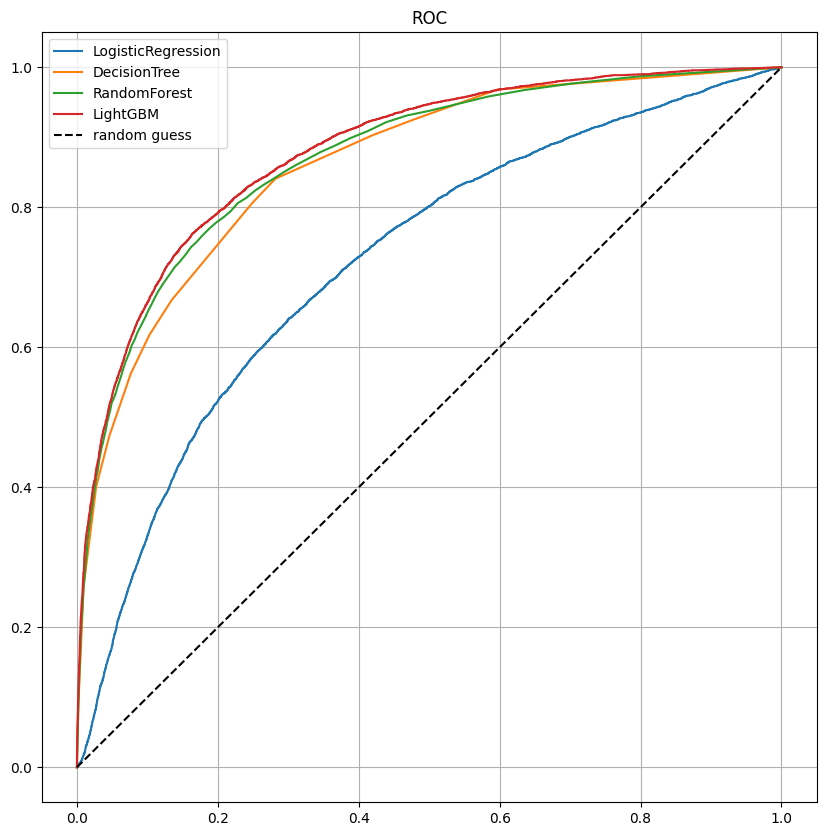

In [40]:
draw_roc_curve(models, model_names, X_test, y_test)

# 2. 오버 샘플링 적용

- 여러 모델 적용
  - remote 오버 샘플링 적용
  - LogisticRegression, DecisionTree, RandomForest, LightGBM

In [41]:
lr_clf = LogisticRegression(random_state=42, solver='liblinear')

dt_clf = DecisionTreeClassifier(random_state=42, max_depth=4)

rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=100)

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, random_state=42, n_jobs=-1)

In [44]:
models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['LogisticRegression', 'DecisionTree', 'RandomForest', 'LightGBM']

results = get_result_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)

results

=> confusion matrix
[[18194  7829]
 [ 2243  4741]]
Accuracy : 0.6949, Precision : 0.3772
Recall : 0.6788, F1 : 0.4849, AUC : 0.7409
Fit time :  0.16136837005615234

=> confusion matrix
[[23169  2854]
 [ 2678  4306]]
Accuracy : 0.8324, Precision : 0.6014
Recall : 0.6166, F1 : 0.6089, AUC : 0.8545
Fit time :  0.09836053848266602

=> confusion matrix
[[23966  2057]
 [ 2845  4139]]
Accuracy : 0.8515, Precision : 0.6680
Recall : 0.5926, F1 : 0.6281, AUC : 0.8702
Fit time :  0.05987811088562012

[LightGBM] [Info] Number of positive: 104090, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1551
[LightGBM] [Info] Number of data points in the train set: 208180, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

,accuracy,precision,recall,f1,roc_auc
LogisticRegression,0.694853,0.377168,0.678837,0.484914,0.740874
DecisionTree,0.832399,0.601397,0.616552,0.608880,0.854530
RandomForest,0.851486,0.668012,0.592640,0.628073,0.870170
LightGBM,0.862787,0.724119,0.567869,0.636546,0.881280


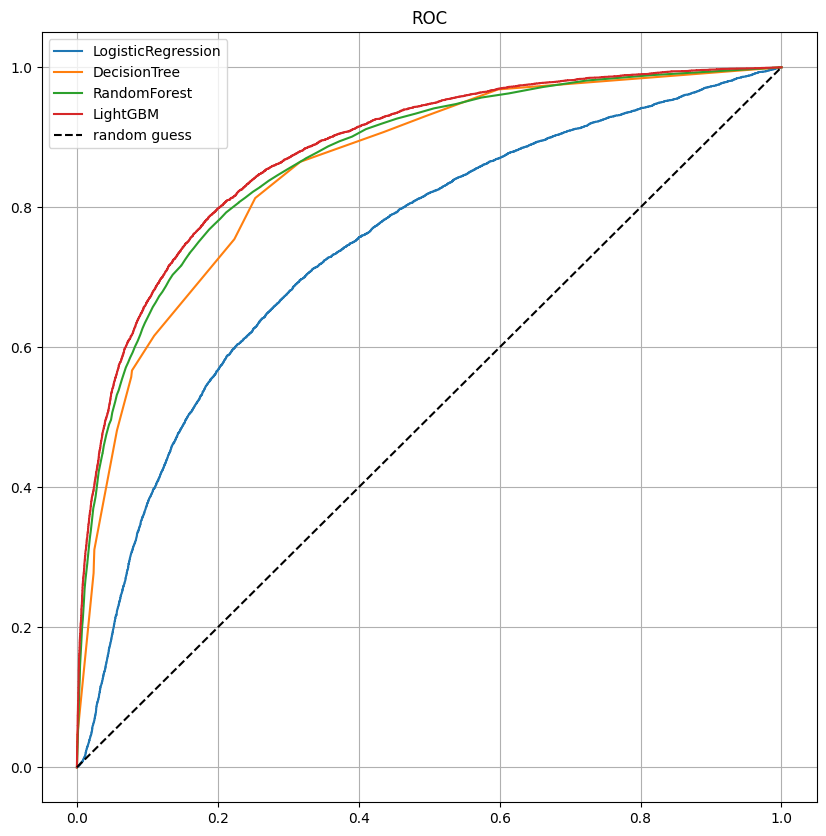

In [45]:
draw_roc_curve(models, model_names, X_test, y_test)

- 오버 샘플링 적용하고 모델링 진행한 결과
- --> LogisticRegression, DecisionTree, RandomForest, LightGBM 순으로 recall을 제외한 모든 지표에서 높은 값을 기록
- --> 확실이 오버샘플링을 적용하고 보니, 모든 모델의 성능이 각자 다 개선된 것을 확인 가능
- --> roc_curve를 통해서 LightGBM의 성능이 가장 좋은 것을 확인했지만, 실제 이탈한 사람 중에서 이탈을 했다고 예측하는 값의 비율을 나타내는 지표인 recall에서 가장 낮은 값을 기록

# 3. 그리드 서치

In [65]:
lr_clf = LogisticRegression(random_state=42, solver='liblinear')

dt_clf = DecisionTreeClassifier(random_state=42, max_depth=4)

rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=100)

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, random_state=42, n_jobs=-1)

- 그리드 서치
  - LogisticRegression

In [67]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
}

grid = GridSearchCV(estimator = lr_clf, param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1, cv=5)

grid.fit(X_train_over, y_train_over)
lr_best = grid.best_estimator_

print('Gridsearch by using AUC')
print('best parameter : {}'.format(grid.best_params_))
print('best AUC score of CV : {:.3f}'.format(grid.best_score_))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solv

Gridsearch by using AUC
best parameter : {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
best AUC score of CV : 0.869


- --> C : 모델의 정규화 강도를 조절하는 역수, 작은 값일수록 훈련데이터에 과적합 되는 것을 방지
- --> penalty : 정규화에 사용되는 패널티의 종류를 지정
  -  l1 : 모델의 가중치 중 많은 것을 0으로 만듦, 희소한 모델을 생성 가능

- 그리드 서치
  - DecisionTree

In [68]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


grid = GridSearchCV(estimator=dt_clf, param_grid=param_grid, scoring='roc_auc', cv=5)


grid.fit(X_train_over, y_train_over)
dt_best = grid.best_estimator_

print('Gridsearch by using AUC')
print('best parameter : {}'.format(grid.best_params_))
print('best AUC score of CV : {:.3f}'.format(grid.best_score_))

Gridsearch by using AUC
best parameter : {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'splitter': 'best'}
best AUC score of CV : 0.943


- 그리드 서치
  - RandomForest

In [72]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini'],
    'max_depth': [10, 14],
    'min_samples_split': [8, 10, 12],
    'min_samples_leaf': [4, 6, 10 ]
}

grid = GridSearchCV(estimator=rf_clf, param_grid=param_grid, scoring='roc_auc', cv=3)


grid.fit(X_train_over, y_train_over)
rf_best = grid.best_estimator_

print('Gridsearch by using AUC')
print('best parameter : {}'.format(grid.best_params_))
print('best AUC score of CV : {:.3f}'.format(grid.best_score_))

Gridsearch by using AUC
best parameter : {'criterion': 'gini', 'max_depth': 14, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 200}
best AUC score of CV : 0.951


- 그리드 서치
  - LightGBM

In [73]:
param_grid = {'booster': ['gbtree'],
             'objective' : ['binary'],
             'learning_rate':[0.01, 0.05, 0.1, 0.2],
             'num_leaves' : [12,34,72]}

grid = GridSearchCV(estimator = lgbm_clf, param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1, cv=5)

grid.fit(X_train_over, y_train_over)
lgbm_best = grid.best_estimator_

print('best parameter : {}'.format(grid.best_params_))
print('best score of CV : {:.3f}'.format(grid.best_score_))
print('best score of test set : {:.3f}'.format(grid.score(X_test,y_test)))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Info] Number of positive: 104090, number of negative: 104090
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1551
[LightGBM] [Info] Number of data points in the train set: 208180, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
best parameter : {'booster': 'gbtree', 'learning_rate': 0.05, 'num_leaves': 34, 'objective': 'binary'}
best score of CV : 0.967
[LightGBM] [Warning] Unknown parameter: booster
best score of test set : 0.888


# 4. 최적의 모델

In [74]:
models = [lr_best, dt_best, rf_best, lgbm_best]

model_names = ['LogisticRegression', 'DecisionTree', 'RandomForest', 'LightGBM']

results = get_result_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)

results

=> confusion matrix
[[20602  5421]
 [ 2290  4694]]
Accuracy : 0.7664, Precision : 0.4641
Recall : 0.6721, F1 : 0.5490, AUC : 0.7939
Fit time :  0.10183405876159668

=> confusion matrix
[[23435  2588]
 [ 2527  4457]]
Accuracy : 0.8450, Precision : 0.6326
Recall : 0.6382, F1 : 0.6354, AUC : 0.8733
Fit time :  0.05815243721008301

=> confusion matrix
[[23662  2361]
 [ 2515  4469]]
Accuracy : 0.8523, Precision : 0.6543
Recall : 0.6399, F1 : 0.6470, AUC : 0.8815
Fit time :  0.06107306480407715

[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Info] Number of positive: 104090, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1551
[LightGBM] [Info] Number of data points in the train set: 208180, number of 

,accuracy,precision,recall,f1,roc_auc
LogisticRegression,0.766383,0.464063,0.672108,0.549038,0.793898
DecisionTree,0.845033,0.632647,0.638173,0.635398,0.873296
RandomForest,0.852274,0.654319,0.639891,0.647025,0.881455
LightGBM,0.863605,0.719568,0.582331,0.643716,0.887555


- --> 모든 모델에서 전부 다 roc_auc 성능이 좋아진 것을 확인 가능
- --> 하지만 LogisticRegression에서는 오히려 디폴트 값인 l2일 때의 모델보다 recall이 더 떨어졌음

[LightGBM] [Warning] Unknown parameter: booster


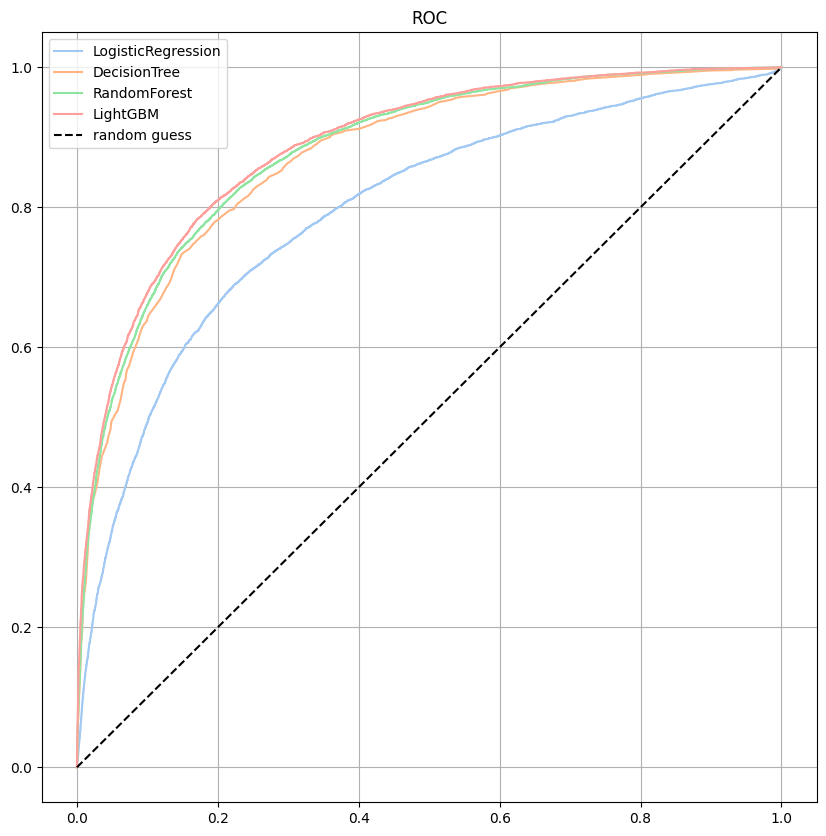

In [75]:
draw_roc_curve(models, model_names, X_test, y_test)

- 정리
  - 확실히 불균형 데이터 모델링에 대해서는 오버샘플링 적용한 데이터에 대해 성능이 좋음
  - lightGBM, 랜덤포레스트에서의 성능이 가장 좋음
  - roc_curve를 통해서 전체적으로는 LightGBM의 성능이 가장 좋은 것을 확인했지만,
  실제 이탈한 사람 중에서 이탈을 했다고 예측하는 값의 비율을 나타내는 지표인 recall에서 가장 낮은 값을 기록했으므로 recall이 중요한 성능 지표로 고려될 때에는 다른 모델 사용이 적합해보임